# Install and Import Libraries

In [ ]:
# Install python version of causal impact
!pip install pycausalimpact

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Data processing
import pandas as pd
import numpy as np
from datetime import datetime

# Create synthetic time-series data
from statsmodels.tsa.arima_process import ArmaProcess

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Causal impact
from causalimpact import CausalImpact

# Create Dataset

Create a synthetic time-series dataset for the causal impact analysis. The benefit of using a synthetic dataset is that we can validate the accuracy of the model results.

The CausalImpact package requires two types of time series:
* A response time series that is directly affected by the intervention.
* And one or more control time series that are not impacted by the intervention.

The idea is to build a time series model to predict the counterfactual outcome. In other words, the model will use the control time series to predict what the response time series outcome would have been if there was no intervention.

In this example, we created one response time series variable and one control time series variable.
* To make the dataset reproducible, a random seed is set at the beginning of the code.
* Then an autoregressive moving average (ARMA) process is created. The autoregressive (AR) part has two coefficients 0.95 and 0.05, and the moving average (MA) part has two coefficients 0.6 and 0.3.
* After creating the autoregressive moving average (ARMA) process, 500 samples are generated from the process.
* The control time series variable `X` is created by adding a constant value of 10 to the generated values.
* The response time series variable `y` is a function of the control time series variable `X`. It equals 2 times `X` plus a random value.
* The intervention happens at the index of 300, and the true causal impact is 10.


In [ ]:
# Set up a seed for reproducibility
np.random.seed(42)

# Autoregressive coefficients
arparams = np.array([.95, .05])

# Moving average coefficients
maparams = np.array([.6, .3])

# Create a ARMA process
arma_process = ArmaProcess.from_coeffs(arparams, maparams)

# Create the control time-series
X = 10 + arma_process.generate_sample(nsample=500)

# Create the response time-series
y = 2 * X + np.random.normal(size=500)

# Add the true causal impact
y[300:] += 10

A time series usually has a time variable indicating the frequency of the data collected. We created 500 dates beginning on January 1st, 2021 using the pandas `date_range` function, indicating the dataset has daily data.

After that, a pandas dataframe is created with the control variable `X`, the response varialbe `y`, and the `dates` as index.

In [ ]:
# Create dates
dates = pd.date_range('2021-01-01', freq='D', periods=500)

# Create dataframe
df = pd.DataFrame({'dates': dates, 'y': y, 'X': X}, columns=['dates', 'y', 'X'])

# Set dates as index
df.set_index('dates', inplace=True)

# Take a look at the data
df.head()

,y,X
dates,,
2021-01-01,21.919606,10.496714
2021-01-02,23.172702,10.631643
2021-01-03,21.278713,11.338640
2021-01-04,26.909878,13.173454
2021-01-05,27.260727,13.955685


# Set Pre and Post Periods

Set the pre and the post intervention periods.

Using `df.index`, we can see that The time-series start date is `2021-01-01`, the time-series end date is `2022-05-15`, and the treatment start date is `2021-10-28`.

In [ ]:
# Print out the time series start date
print(f'The time-series start date is :{df.index.min()}')

# Print out the time series end date
print(f'The time-series end date is :{df.index.max()}')

# Print out the intervention start date
print(f'The treatment start date is :{df.index[300]}')

The time-series start date is :2021-01-01 00:00:00
The time-series end date is :2022-05-15 00:00:00
The treatment start date is :2021-10-28 00:00:00


Next, let's visualize the time-series data.

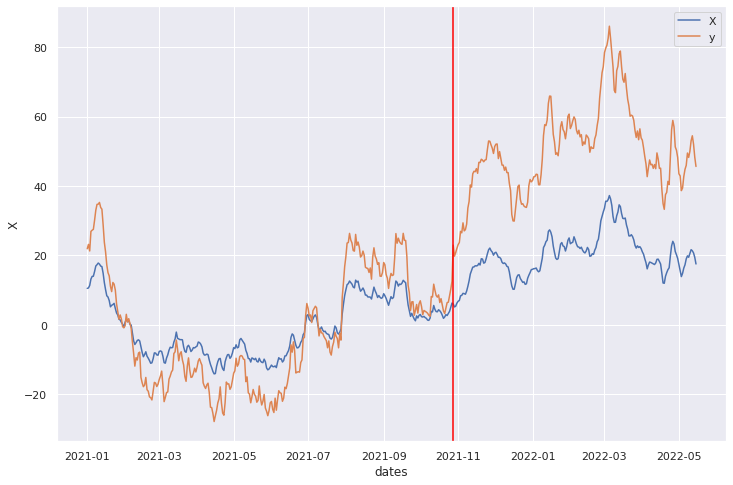

In [ ]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=df.index, y=df['X'])
sns.lineplot(x=df.index, y=df['y'])
plt.axvline(x= df.index[300], color='red')
plt.legend(labels = ['X', 'y'])

In the chart, the blue line is the control time series, the orange line is the response time series, and the red vertical line represents the intervention start date.

We can see that before the intervention, the control and response time series have similar values. After the intervention, the response time series consistently has higher values than the control time series.

The python `CausalImpact` package requires the pre and the post periods inputs in a list format. The first element in the list is the starting index and the last element in the list is the ending index.

The intervention start date is `2021-10-28`, so the pre-period ends at `2021-10-27`.

In [ ]:
# Set pre-period
pre_period = [str(df.index.min())[:10], str(df.index[299])[:10]]

# Set post-period
post_period = [str(df.index[300])[:10], str(df.index.max())[:10]]

# Print out the values
print(f'The pre-period is {pre_period}')
print(f'The post-period is {post_period}')

The pre-period is ['2021-01-01', '2021-10-27']
The post-period is ['2021-10-28', '2022-05-15']


# Raw Differences

We will calculate the raw difference between the pre and the post periods.

We can see that the pre-treatment daily average is -1.64, the post-treatment daily average is 50.08, and the raw difference between the pre and the post treatment is 51.7, which is much higher than the true causal impact of 10.

Without causality analysis, we will overestimate the causal impact.

In [ ]:
# Calculate the pre-daily average
pre_daily_avg = df['y'][:300].mean()

# Calculate the post-daily average
post_daily_avg = df['y'][300:].mean()

# Print out the results
print(f'The pre-treatment daily average is {pre_daily_avg}.')
print(f'The post-treatment daily average is {post_daily_avg}.')
print(f'The raw difference between the pre and the post treatment is {post_daily_avg - pre_daily_avg}.')

The pre-treatment daily average is -1.6403416947312546.
The post-treatment daily average is 50.08461262581729.
The raw difference between the pre and the post treatment is 51.72495432054855.


# Causal Impact Analysis on Time Series

Execute the causal impact analysis on the time series.

The causality analysis has two assumptions:
* Assumption 1: There are one or more control time series that are highly correlated with the response variable, but not impacted by the intervention. Violation of this assumption can result in wrong conclusions about the existence, the direction, or the magnitude of the treatment effect.
* Assumption 2: The correlation between the control and the response time series is the same for pre and post intervention.

The synthetic time series data we created satisfy the two assumptions.

The python `CausalImpact` package has a function called `CausalImpact` that implements a Bayesian Structural Time Series Model (BSTS) on the backend. It has three required inputs:
* `data` takes the python dataframe name.
* `pre_period` takes the starting and the ending index values for the pre-intervention period.
* `post_period` takes the starting and the ending index values for the post-intervention period.

After saving the output object in a variable called `impact`, we can run `impact.plot()` to visualize the results.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


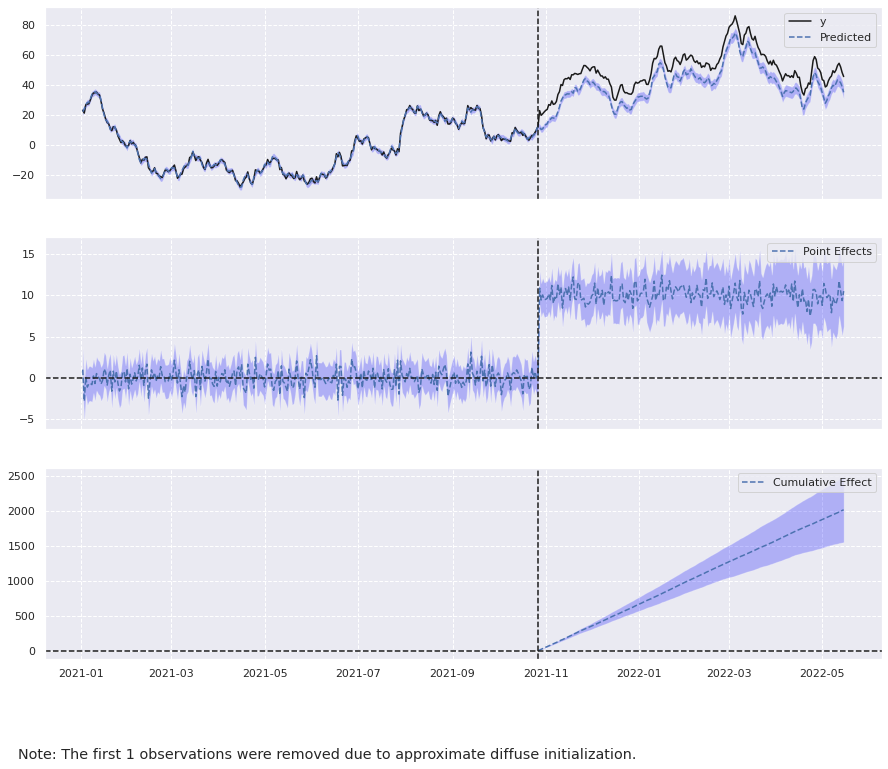

In [ ]:
# Causal impact model
impact = CausalImpact(data=df, pre_period=pre_period, post_period=post_period)

# Visualization
impact.plot()

The visualization consists of three charts:
* The first chart plots the predicted counterfactual values and the actual values for the post-period.
* The second chart plots the point effects, which are the differences between the actual and predicted values. We can see that the pre-period point effects values are all around 0, and the post-period point effects values are all around the true impact of 10.
* The third chart plots the cumulative effect, which is the cumulative sum of the point effects from the second chart.

# Time Series Causal Impact Summary

Summarize the causal impact of the intervention for the time series.

The summary from `impact.summary()` tells us that:
* The actual post-intervention average is 50.08, and the predicted post-intervention average is 40.3.
* The absolute causal effect is 10.06, which is very close to the true impact of 10, and much better than the raw difference of 51.7.
* The relative causal effect is 25.12%.
* The posterior probability of a causal effect is 100%, showing that the model is very confident that the causal impact exists.

In [ ]:
# Causal impact summary
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    50.08              10016.92
Prediction (s.d.)         40.03 (1.2)        8005.59 (239.36)
95% CI                    [37.64, 42.33]     [7527.61, 8465.89]

Absolute effect (s.d.)    10.06 (1.2)        2011.33 (239.36)
95% CI                    [7.76, 12.45]      [1551.03, 2489.31]

Relative effect (s.d.)    25.12% (2.99%)     25.12% (2.99%)
95% CI                    [19.37%, 31.09%]   [19.37%, 31.09%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


# Report Summary

In [ ]:
# Causal impact report
print(impact.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 50.08. By contrast, in the absence of an
intervention, we would have expected an average response of 40.03.
The 95% interval of this counterfactual prediction is [37.64, 42.33].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 10.06 with a 95% interval of
[7.76, 12.45]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 10016.92.
By contrast, had the intervention not taken place, we would have expected
a sum of 8005.59. The 95% interval of this prediction is [7527.61, 8465.89].


The above results are given in terms of absolute numbers. In relative
terms, the response va

The `pycausalimpact` package documentation highly recommends setting the `prior_level_sd` to `None`, which will let `statsmodel` do the optimization for the prior on the local level component.

Based on this suggestion, a version with the option `prior_level_sd=None` is created.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


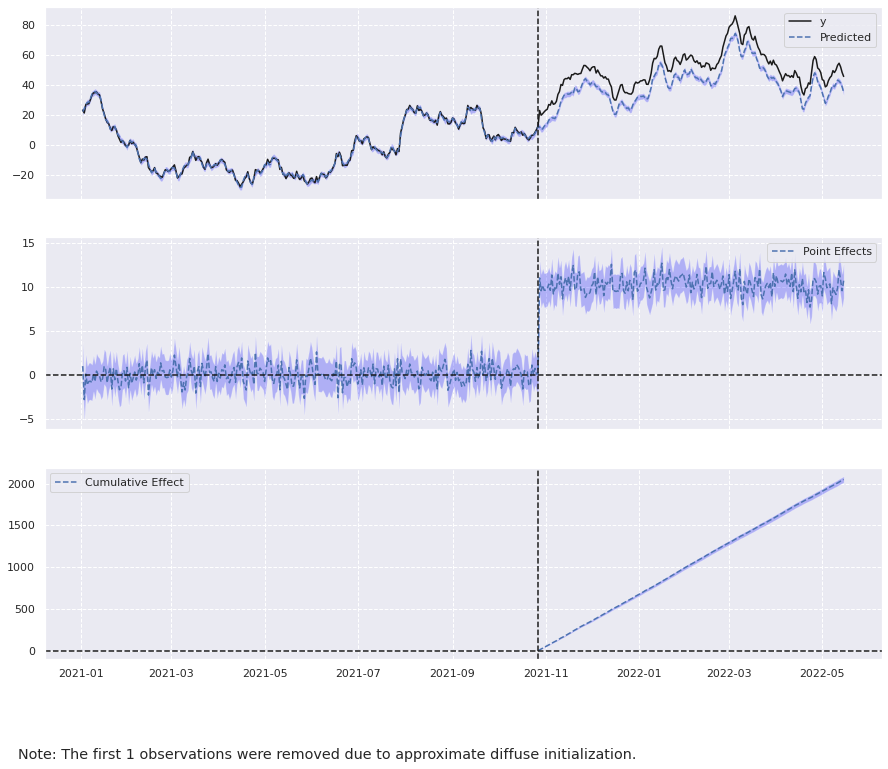

In [ ]:
# Causal impact model without prior level sd
impact_no_prior_level_sd = CausalImpact(df, pre_period, post_period, prior_level_sd=None)

# Plot the results
impact_no_prior_level_sd.plot()

We can see that the point estimation values are similar, but the standard deviations are smaller for the estimation.

In [ ]:
# Print out the summary
print(impact_no_prior_level_sd.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    50.08              10016.92
Prediction (s.d.)         39.84 (0.09)       7967.47 (18.41)
95% CI                    [39.65, 40.01]     [7929.85, 8001.99]

Absolute effect (s.d.)    10.25 (0.09)       2049.45 (18.41)
95% CI                    [10.07, 10.44]     [2014.93, 2087.08]

Relative effect (s.d.)    25.72% (0.23%)     25.72% (0.23%)
95% CI                    [25.29%, 26.19%]   [25.29%, 26.19%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
